# 加载数据和包

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import pickle


In [5]:
churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 探索数据和数据类型

In [6]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 🧾 1. 客户信息字段
| 字段名             | 类型         | 说明                    |
| --------------- | ---------- | --------------------- |
| `customerID`    | 字符串（ID）    | 唯一标识符，无建模价值，应该从模型中剔除  |
| `gender`        | 类别         | 男/女，可能与流失略有关联（但通常作用小） |
| `SeniorCitizen` | 数值（0/1）    | 是否为老年人（可视作布尔变量）       |
| `Partner`       | 类别（Yes/No） | 是否有配偶（可能影响留存意愿）       |
| `Dependents`    | 类别（Yes/No） | 是否有家属/小孩，表示经济负担情况     |

### ⏳ 2. 服务使用相关
| 字段名                | 类型               | 说明                       |
| ------------------ | ---------------- | ------------------------ |
| `tenure`           | 数值型              | 使用了几个月，**非常关键特征**        |
| `PhoneService`     | 类别（Yes/No）       | 是否有电话服务                  |
| `MultipleLines`    | 类别               | 是否有多条电话线                 |
| `InternetService`  | 类别（DSL/Fiber/No） | 上网类型，**Fiber 用户流失率往往更高** |
| `OnlineSecurity`   | 类别               | 是否订购网络安全服务               |
| `DeviceProtection` | 类别               | 是否有设备保护服务                |
| `TechSupport`      | 类别               | 是否订购技术支持                 |
| `StreamingTV`      | 类别               | 是否使用电视流媒体服务              |
| `StreamingMovies`  | 类别               | 是否使用电影流媒体服务              |

### 📃 3. 合同与付费相关
| 字段名                | 类型                                     | 说明                     |
| ------------------ | -------------------------------------- | ---------------------- |
| `Contract`         | 类别（Month-to-month, One year, Two year） | **重要特征**，长期合同客户流失率显著较低 |
| `PaperlessBilling` | 类别（Yes/No）                             | 是否无纸账单（可能关联客户行为习惯）     |
| `PaymentMethod`    | 类别                                     | 支付方式（信用卡、银行转账、电子支票等）   |
| `MonthlyCharges`   | 数值型                                    | 每月收费金额，高额可能增加流失风险      |
| `TotalCharges`     | 数值型                                    | 总计花费，部分缺失值需清洗处理        |


In [7]:
churn_data.info()
print(churn_data.shape)
churn_data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

TotalCharges 应该为float64但data文件中是object

# 数据预处理

## 缺失值处理

In [8]:
# 将 TotalCharges 列转换为数值类型，无法转换的值将被设置为 NaN
churn_data.TotalCharges = pd.to_numeric(churn_data.TotalCharges, errors='coerce')

print(churn_data.isnull().sum())
print('There are {} rows with missing values'.format(churn_data[churn_data.isnull().any(axis=1)].shape[0]))
# missing_rows_index = churn_data[churn_data.TotalCharges.isnull()].index.tolist()
# churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv') 
# print(churn_data.iloc[missing_rows_index]) 

# 删除 TotalCharges 列中有缺失值的行
churn_data = churn_data.dropna(subset=['TotalCharges'])
# 还有哪些行的 tenure 为 0
churn_data[churn_data.tenure == 0].index

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
There are 11 rows with missing values


Index([], dtype='int64')

TotalCharges 里面有缺失值是因为有刚注册的用户，tenure为。因为只分析长期使用而流失的客户，所以将这11个用户删除。

## 变量编码

- 将customerID 设为index
- 将SeniorCitizen 的0,1 改为分类变量

In [9]:
try:
    churn_data = churn_data.set_index('customerID')
except:
    print("customerID column not found or already set as index.")

churn_data.rename(columns = {'gender': 'Gender'}, inplace=True)
churn_data.Gender = churn_data.Gender.astype('category')
churn_data.SeniorCitizen = churn_data.SeniorCitizen.map({1: 'Yes', 0: 'No'}).astype('category')
churn_data.Partner = churn_data.Partner.astype('category')
churn_data.Dependents = churn_data.Dependents.astype('category')
churn_data.PhoneService = churn_data.PhoneService.astype('category')
churn_data.MultipleLines = churn_data.MultipleLines.astype('category')
churn_data.InternetService = churn_data.InternetService.astype('category')
churn_data.OnlineSecurity = churn_data.OnlineSecurity.astype('category')
churn_data.OnlineBackup = churn_data.OnlineBackup.astype('category')
churn_data.DeviceProtection = churn_data.DeviceProtection.astype('category')
churn_data.TechSupport = churn_data.TechSupport.astype('category')
churn_data.StreamingTV = churn_data.StreamingTV.astype('category')
churn_data.StreamingMovies = churn_data.StreamingMovies.astype('category')
churn_data.Contract = churn_data.Contract.astype('category')
churn_data.PaperlessBilling = churn_data.PaperlessBilling.astype('category')
churn_data.PaymentMethod = churn_data.PaymentMethod.astype('category')
churn_data.Churn = churn_data.Churn.astype('category')

churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod 

In [10]:
churn_data.SeniorCitizen.unique()
churn_data.SeniorCitizen.value_counts()

SeniorCitizen
No     5890
Yes    1142
Name: count, dtype: int64

# 数据可视化

### 流失率的饼图

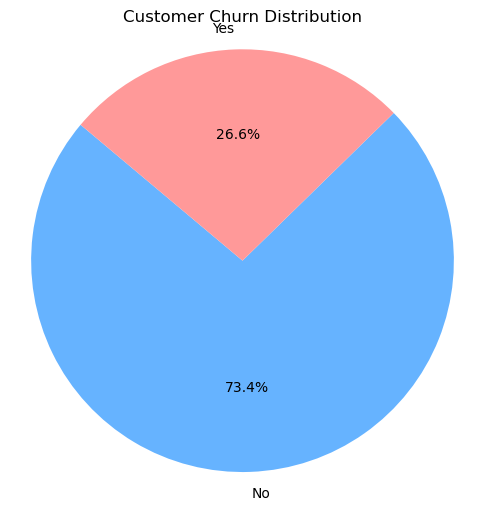

In [11]:
# 计算每类客户的数量
churn_counts = churn_data['Churn'].value_counts()

# 设置标签和颜色（可选）
labels = churn_counts.index
sizes = churn_counts.values
colors = ['#66b3ff', '#ff9999']

# 画饼图
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Customer Churn Distribution')
plt.axis('equal')  # 保证饼图是圆的
plt.show()

### 以是否流失分组，显示每组每个属性不同类别的占比

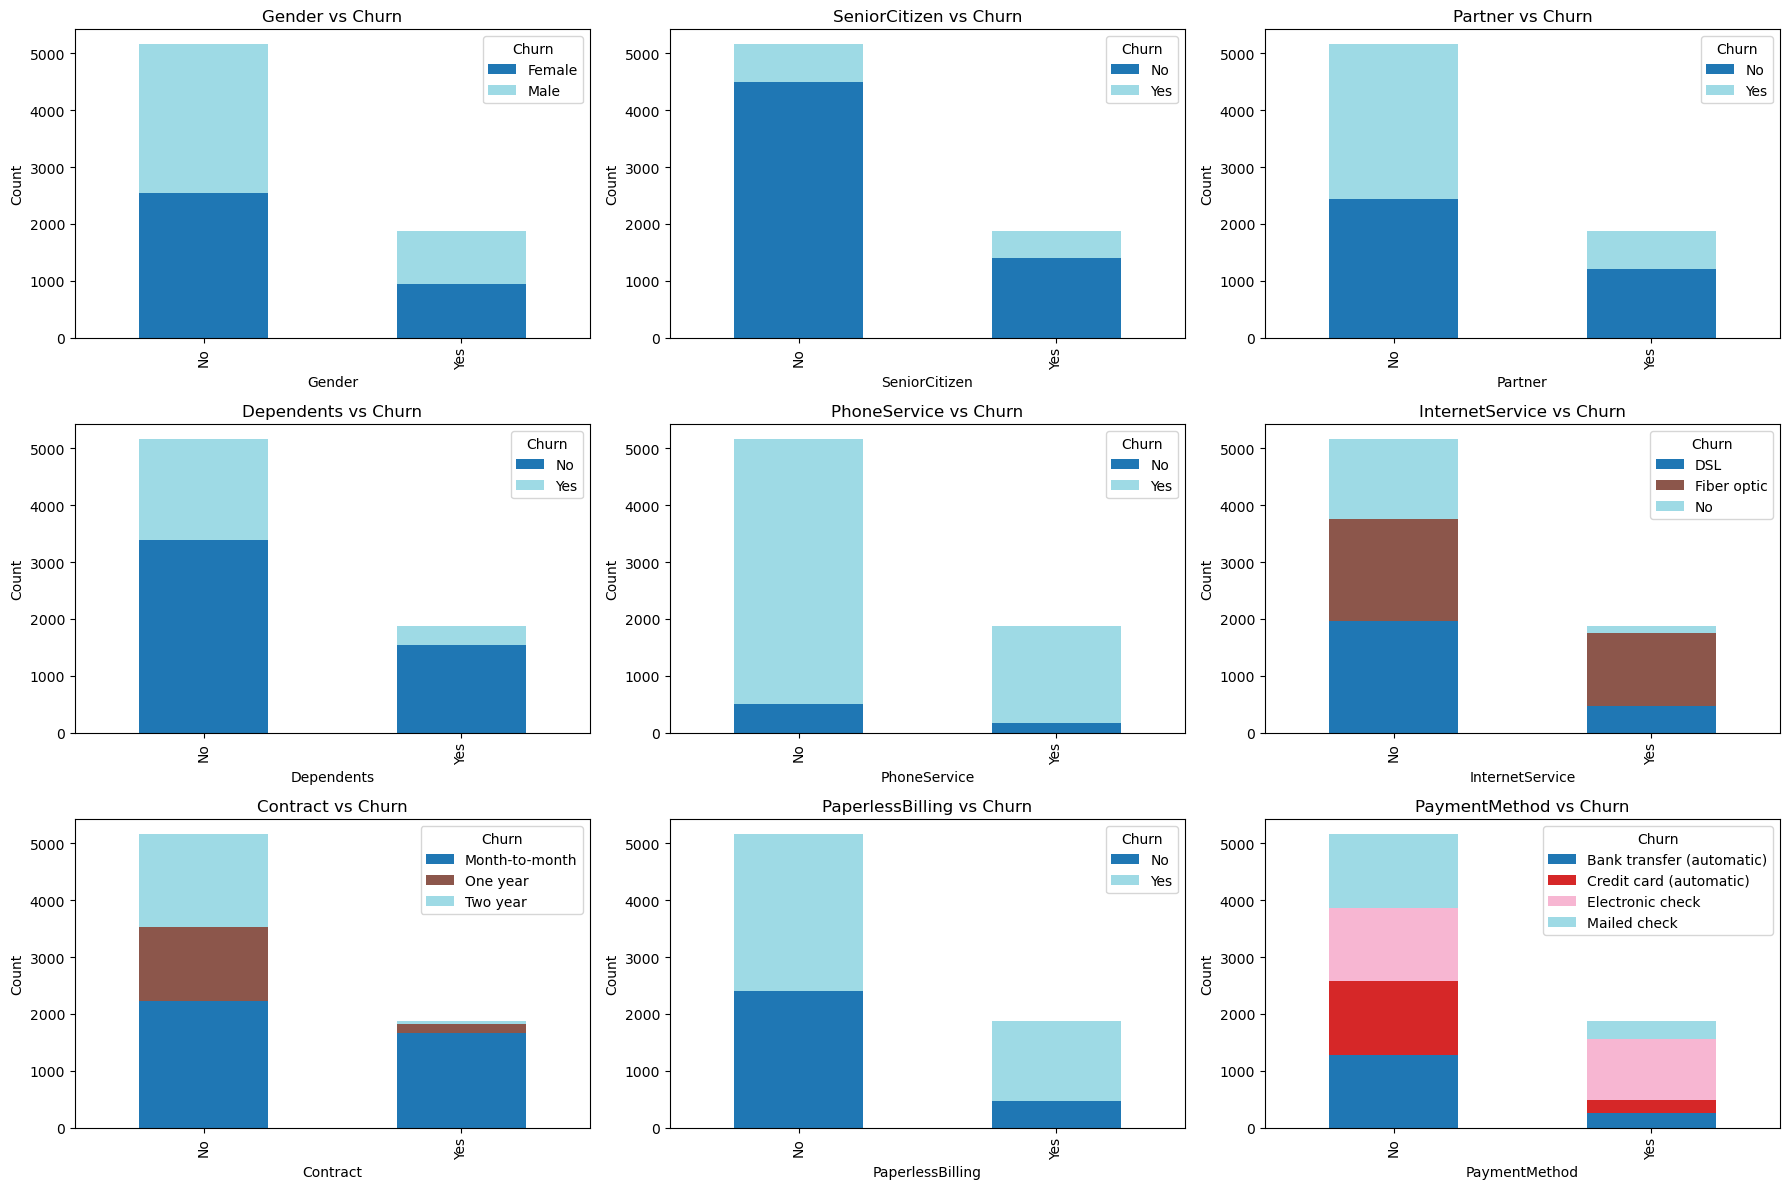

In [12]:
# 要分析的分类变量
cols = [
    'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'InternetService', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

# 创建画布和子图
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()  # 展平成一维，方便迭代赋图

# 逐个变量画堆叠柱状图
for i, col in enumerate(cols):
    pd.crosstab(churn_data['Churn'], churn_data[col], ).plot(
        kind='bar',
        stacked=True,
        ax=axes[i],
        colormap='tab20'  # 你也可以换其他 colormap
    )
    axes[i].set_title(f'{col} vs Churn')
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Churn')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

### 比较 MonthlyCharges, TotaoCharges, Tenure 在 Churn=Yes 与 No 之间的分布差异。

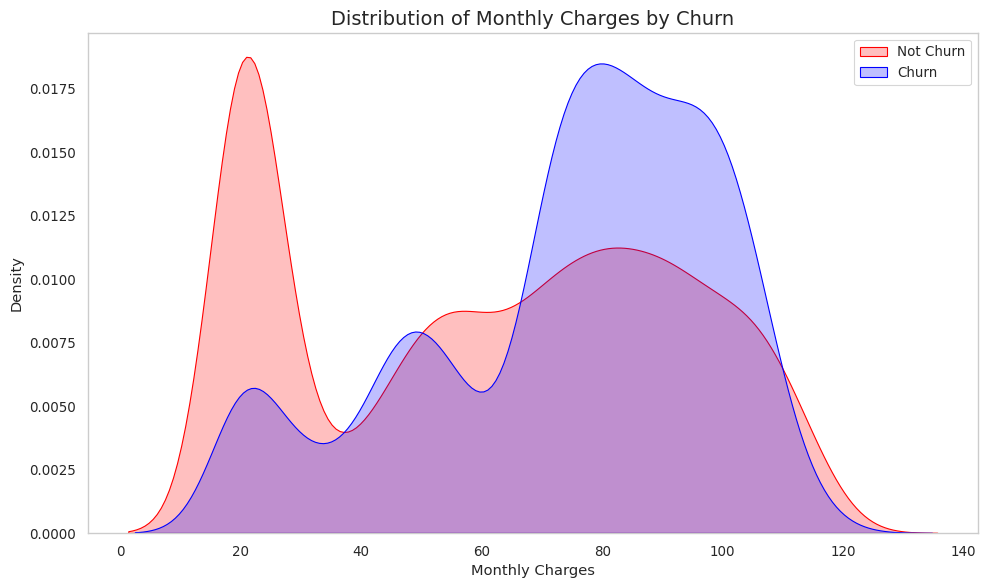

<Figure size 640x480 with 0 Axes>

In [13]:
# 设置图形风格与字体大小
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

# 创建图形
plt.figure(figsize=(10, 6))

# KDE 密度图：Churn = No
ax = sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'No'],
    x="MonthlyCharges",
    fill=True,
    color="red",
    label="Not Churn"
)

# KDE 密度图：Churn = Yes
sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'Yes'],
    x="MonthlyCharges",
    fill=True,
    color="blue",
    label="Churn",
    ax=ax
)

# 添加图形元素
ax.set_title('Distribution of Monthly Charges by Churn', fontsize=14)
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Density')
ax.legend(loc='upper right')
ax.grid(False)
plt.tight_layout()
plt.show()
plt.clf()

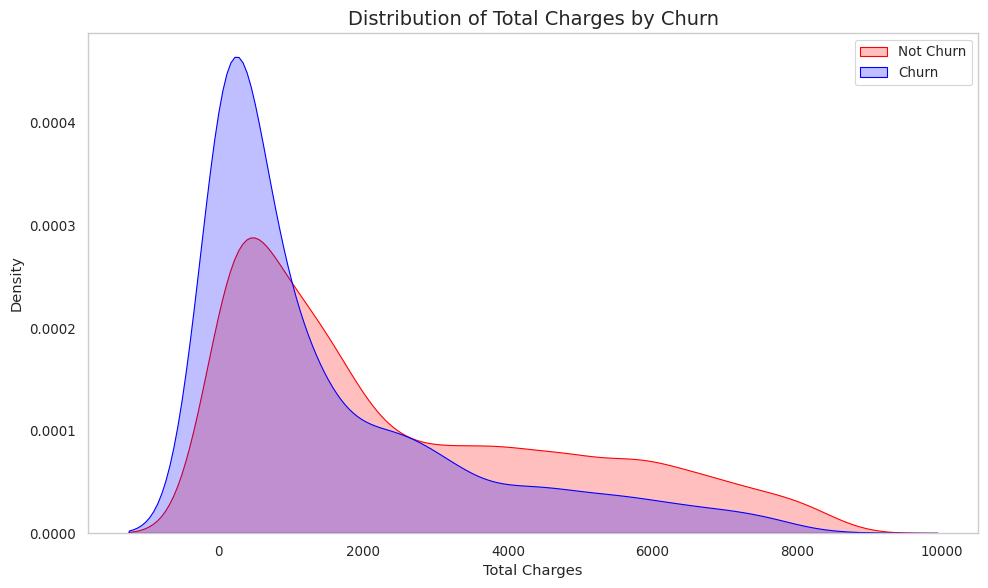

In [14]:
# 设置图形风格与字体大小
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

# 创建图形
plt.figure(figsize=(10, 6))

# KDE 密度图：Churn = No
ax = sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'No'],
    x="TotalCharges",
    fill=True,
    color="red",
    label="Not Churn"
)

# KDE 密度图：Churn = Yes
sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'Yes'],
    x="TotalCharges",
    fill=True,
    color="blue",
    label="Churn",
    ax=ax
)

# 添加图形元素
ax.set_title('Distribution of Total Charges by Churn', fontsize=14)
ax.set_xlabel('Total Charges')
ax.set_ylabel('Density')
ax.legend(loc='upper right')
ax.grid(False)
plt.tight_layout()
plt.show()

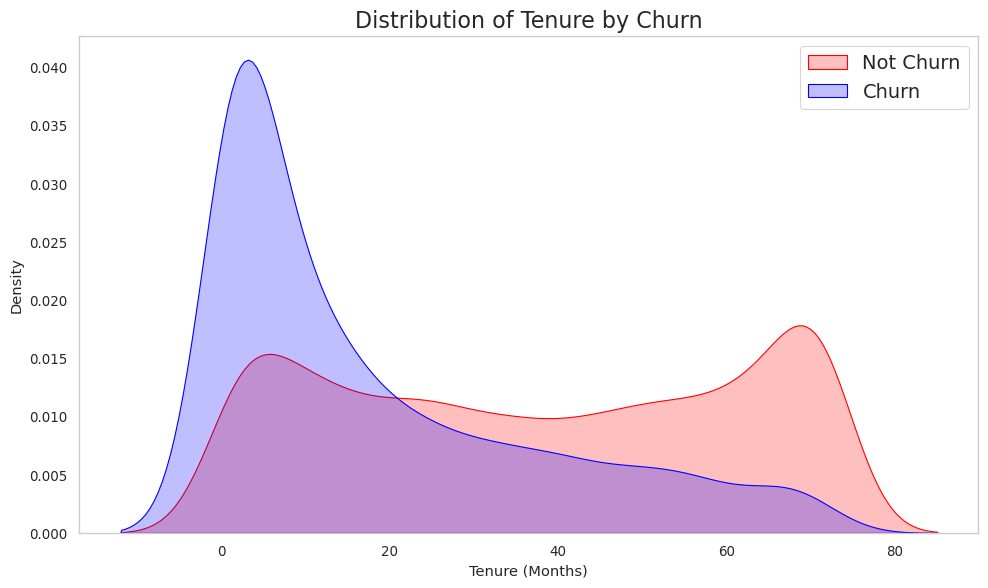

In [15]:
# 设置图形风格与字体大小
sns.set_context("paper", font_scale=1.1)
sns.set_style("whitegrid")

# 创建图形
plt.figure(figsize=(10, 6))

# KDE 密度图：Churn = No
ax = sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'No'],
    x="tenure",
    fill=True,
    color="red",
    label="Not Churn"
)

# KDE 密度图：Churn = Yes
sns.kdeplot(
    data=churn_data[churn_data["Churn"] == 'Yes'],
    x="tenure",
    fill=True,
    color="blue",
    label="Churn",
    ax=ax
)

# 添加图形元素
ax.set_title('Distribution of Tenure by Churn', fontsize=16)
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Density')
ax.legend(loc='upper right', fontsize=14)
ax.grid(False)
plt.tight_layout()
plt.show()

### 各个变量之间的相关性热力图

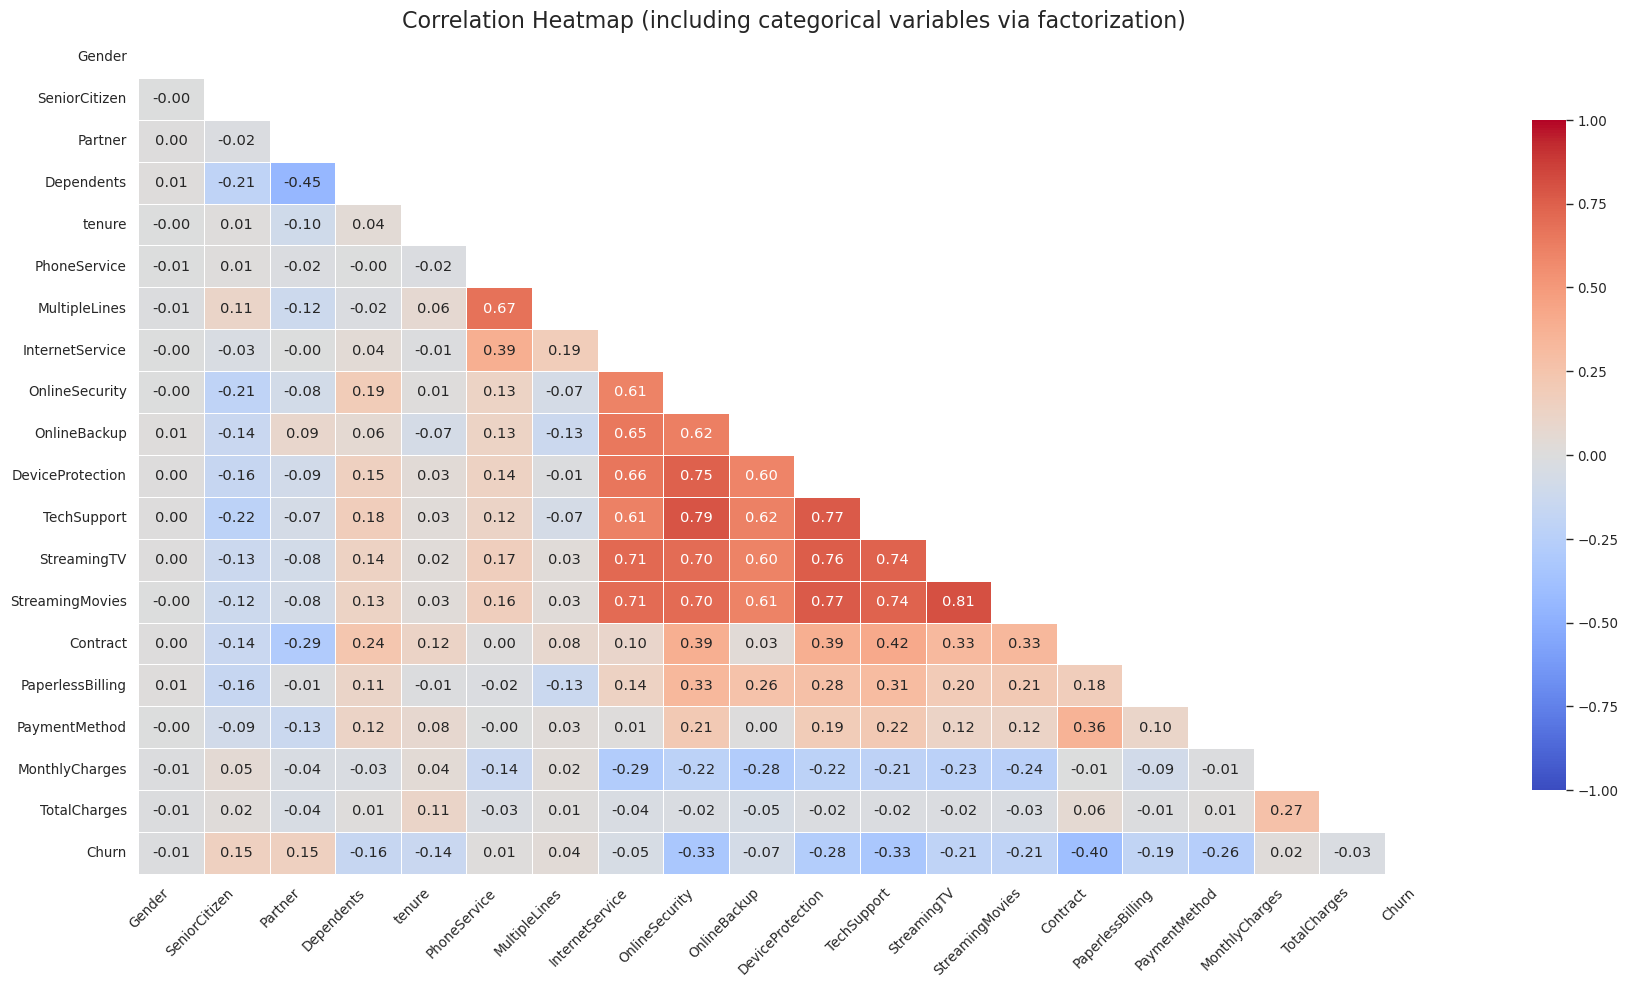

In [16]:
# 将所有列因子化为数值（包括分类变量）
factorized_data = churn_data.apply(lambda x: pd.factorize(x)[0])

# 计算相关性
corr = factorized_data.corr()

# 创建掩码，只显示上三角
mask = np.triu(np.ones_like(corr, dtype=bool))

# 设置图形大小和风格
plt.figure(figsize=(18, 10))
sns.set_style("white")

# 绘制热力图
ax = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1, xticklabels=corr.columns, yticklabels=corr.columns, cbar_kws={"shrink": 0.8})

# 标题和美化
plt.title("Correlation Heatmap (including categorical variables via factorization)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 数据处理

查看三个数值变量是否为偏态分布

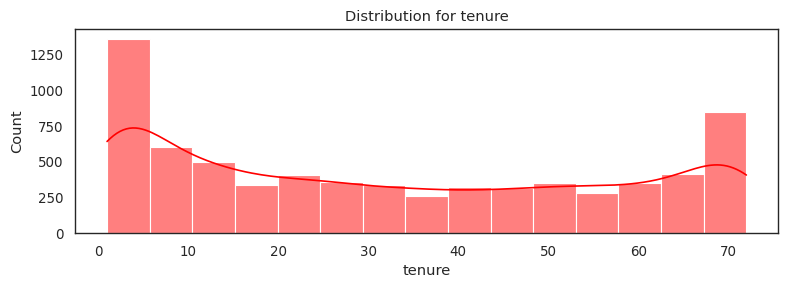

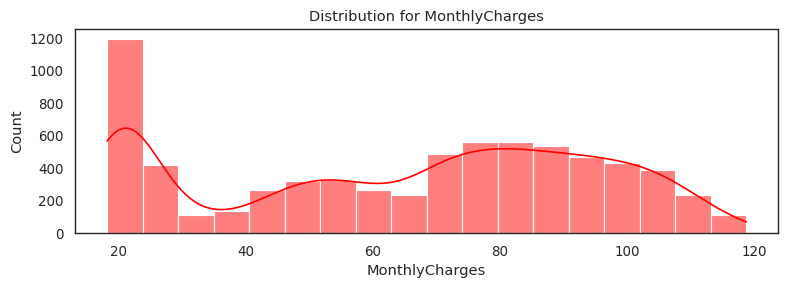

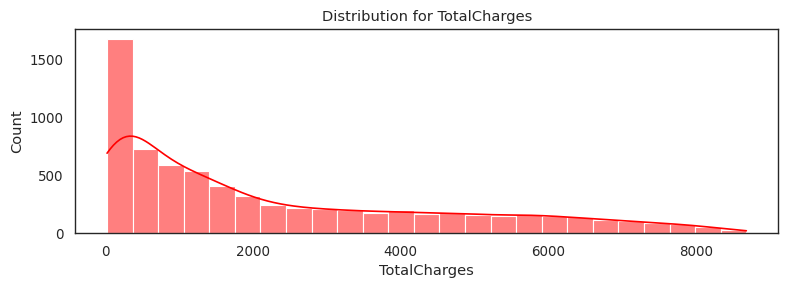

In [17]:
def distplot(feature, dataframe, color='r'):
    plt.figure(figsize=(8, 3))
    plt.title(f"Distribution for {feature}")
    sns.histplot(data=dataframe, x=feature, kde=True, color=color)
    plt.tight_layout()
    plt.show()
    
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for col in num_cols: 
    distplot(col, churn_data)

三个数值变量非正太分布，需要做标准化处理
### 标准化处理

In [18]:
churn_data_std = pd.DataFrame(StandardScaler().fit_transform(churn_data[num_cols]),columns=num_cols)
# for col in num_cols: 
#     distplot(col, churn_data_std, color='c')
    
churn_num = churn_data[num_cols].copy()

In [19]:
cat_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
            'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod']
churn_cat_encoded = pd.get_dummies(churn_data[cat_cols], drop_first=False)


In [20]:
X = pd.concat([churn_cat_encoded, churn_num], axis=1)
y = churn_data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0).astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)

# Machine Learning 模型训练

## Logistics Regression

LogisticRegression 默认的正则化项就是 Ridge

In [21]:
# param_grid_lr = {'penalty': ['l1', 'l2'], 'C': np.linspace(0.01, 10, 1000)}
# grid_lr = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_lr, cv=5, scoring='roc_auc')
# grid_lr.fit(X_train, y_train)
# print("Best penalty:", grid_lr.best_params_)
# print("Best C:", grid_lr.best_params_['C'])

best_lr = LogisticRegression(C= np.float64(0.3), penalty = 'l1', max_iter=1000, solver='liblinear')
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
y_pred_prob = best_lr.predict_proba(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.8137440758293839
Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.90      0.88      1549
        True       0.67      0.58      0.62       561

    accuracy                           0.81      2110
   macro avg       0.76      0.74      0.75      2110
weighted avg       0.81      0.81      0.81      2110



### Bagging for Logistic Regression

In [22]:
# base_lr = LogisticRegression(solver='liblinear')

# # 构建 BaggingClassifier
# bag = BaggingClassifier(estimator=base_lr, random_state=42)

# # 设置参数网格（注意 C 是逻辑回归的参数）
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_samples': [0.7, 0.9],
#     'max_features': [0.7, 1.0],
#     'estimator__C': np.linspace(0.01, 10, 20)  # 缩小数量以避免训练时间太长
# }

# # 网格搜索
# grid_bag_lr = GridSearchCV(bag, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_bag_lr.fit(X_train, y_train)
# print("Best parameters for Bagging Logistic Regression:", grid_bag_lr.best_params_)

# 使用最佳参数的模型进行预测
best_bag_lr = BaggingClassifier( n_estimators = 100, 
                                max_samples = 1.0,
                                max_features = 0.9,
                                estimator=LogisticRegression(C = np.float64(8.948421052631579), solver='liblinear'),
                                )
best_bag_lr.fit(X_train, y_train)
y_pred_bag_lr = best_bag_lr.predict(X_test)
y_pred_prob_bag_lr = best_bag_lr.predict_proba(X_test)
print("Bagging Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_bag_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_bag_lr))

Bagging Logistic Regression Accuracy: 0.8113744075829384
Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.90      0.88      1549
        True       0.67      0.57      0.62       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.75      2110
weighted avg       0.80      0.81      0.81      2110



Bagging for Logistic Regression 的效果并不理想，单个逻辑回归模型已经很稳定，Bagging带来的“去方差”意义不大

## KNN

In [23]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print("KNN Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

KNN Model Performance:
Accuracy: 0.7677725118483413
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.87      0.85      1549
        True       0.57      0.49      0.53       561

    accuracy                           0.77      2110
   macro avg       0.70      0.68      0.69      2110
weighted avg       0.76      0.77      0.76      2110



## SVC

In [24]:
svc_model = SVC(probability=True, random_state=40, class_weight={False: 1, True: 3})
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
print("SVC Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

SVC Model Performance:
Accuracy: 0.6758293838862559
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.70      0.76      1549
        True       0.42      0.60      0.50       561

    accuracy                           0.68      2110
   macro avg       0.63      0.65      0.63      2110
weighted avg       0.72      0.68      0.69      2110



## Decison Tree

### Random Forest Classifier

In [25]:
# param_grid = {
#     'n_estimators': [100, 200, 300],        # 森林中树的数量
#     'max_depth': list(range(5,19,1)),       # 树的最大深度
#     'min_samples_split': [2, 5, 10],        # 节点再划分所需最小样本数
#     'min_samples_leaf': [1, 2, 4],          # 叶子节点最少样本数
#     'max_features': ['sqrt', 'log2', None], # 每棵树使用的最大特征数
#     'bootstrap': [True, False]              # 是否自助采样
# }

# rf = RandomForestClassifier(random_state=42)
# grid_rf = GridSearchCV(
#     rf,
#     param_grid,
#     cv=5,
#     scoring='roc_auc',
#     n_jobs=-1,
#     verbose=1
# )
# grid_rf.fit(X_train, y_train)

# # 最佳模型与结果
# print("Best parameters:", grid_rf.best_params_)
# print("Best CV score:", grid_rf.best_score_)
# Best parameters: {'bootstrap': True, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
# Best CV score: 0.8414792539900633 

# 用测试集评估
best_rf = RandomForestClassifier(random_state=42, 
                                 bootstrap = True, 
                                 max_depth = 7, 
                                 max_features = 'sqrt', 
                                 min_samples_leaf = 4, 
                                 min_samples_split = 10, 
                                 n_estimators = 300)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print("Random Forest Model Performance:")
print("Test Accuracy:", best_rf.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Model Performance:
Test Accuracy: 0.8104265402843602
Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.92      0.88      1549
        True       0.69      0.51      0.59       561

    accuracy                           0.81      2110
   macro avg       0.77      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110



### AdaBoost

In [26]:
# param_grid_gb = {
#     'n_estimators': [100, 200, 400, 600, 800, 1000],  # 树的数量
#     'learning_rate':  [0.01, 0.05, 0.1, 0.5, 1.0] 
#     #新版 scikit-learn 把 SAMME.R 作为默认实现并开始弃用 algorithm 参数
# }
# ada_model = AdaBoostClassifier(random_state=40)
# grid_ada = GridSearchCV(ada_model, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_ada.fit(X_train, y_train)
# print("Best parameters for AdaBoost:", grid_ada.best_params_)

# Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 1000}
 
best_ada = AdaBoostClassifier(random_state=40, 
                              n_estimators=1000, 
                              learning_rate=0.1)
best_ada.fit(X_train, y_train)
y_pred = best_ada.predict(X_test)
print("AdaBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

AdaBoost Model Performance:
Accuracy: 0.8146919431279621
Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.92      0.88      1549
        True       0.70      0.53      0.60       561

    accuracy                           0.81      2110
   macro avg       0.77      0.72      0.74      2110
weighted avg       0.81      0.81      0.81      2110



### LightGBM

训练模型

In [27]:
# param_dist = {
#     'n_estimators': randint(300, 800),
#     'learning_rate': uniform(0.01, 0.09),
#     'num_leaves': randint(20, 100),  # LightGBM 的叶子节点数
#     'max_depth': randint(3, 15),      # 树的最大深度
#     'min_child_samples': randint(10, 50),  # 每个叶子节点的最小样本数
#     'subsample': uniform(0.6, 0.4),   # 训练样本的子采样比例
#     'colsample_bytree': uniform(0.6, 0.4),  # 特征的子采样比例
#     'reg_alpha': uniform(0, 1),       # L1 正则化
#     'reg_lambda': uniform(0, 1),      # L2 正则化
#     'min_split_gain': uniform(0, 0.1)  # 节点分裂的最小增益    
# }

# lgb = LGBMClassifier(
#     objective='binary',
#     random_state=42,
# )

# rs = RandomizedSearchCV(
#     lgb,
#     param_dist,
#     n_iter=60,               # 随机抽 60 组
#     cv=5,
#     scoring='roc_auc',       # 更关注召回/概率质量
#     n_jobs=-1,
#     verbose= 0
# )
# rs.fit(X_train, y_train)
# print("Best params:", rs.best_params_)
# best_lgb = rs.best_estimator_
# print('Best parameters for LightGBM:', best_lgb.get_params())

# best_lgb.fit(X_train, y_train)
# y_pred = best_lgb.predict(X_test)
# print("LightGBM Model Performance:")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

# # 保存
# with open("lightgbm_model.pkl", "wb") as f:
#     pickle.dump(best_lgb, f)

加载最优模型

In [28]:
# 加载
with open("lightgbm_model.pkl", "rb") as f:
    best_lgb = pickle.load(f)
    
best_lgb.fit(X_train, y_train)
y_pred = best_lgb.predict(X_test)
print("LightGBM Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1308, number of negative: 3614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 4922, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265746 -> initscore=-1.016316
[LightGBM] [Info] Start training from score -1.016316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

### Voting Classifier

In [29]:
clf1 = best_lr
clf2 = best_rf
clf3 = best_ada
vote_model = VotingClassifier(estimators=[('LogisticRegression', clf1), ('RandomForest', clf2), ('AdaBoost', clf3)], voting='soft')
vote_model.fit(X_train, y_train)
predictions = vote_model.predict(X_test)
print("Final Accuracy Score ")
print(accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Final Accuracy Score 
0.8165876777251185
Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.91      0.88      1549
        True       0.69      0.55      0.62       561

    accuracy                           0.82      2110
   macro avg       0.77      0.73      0.75      2110
weighted avg       0.81      0.82      0.81      2110



## 模型训练结果

将表现良好的模型指标汇总在表格中

In [30]:
results = []

models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'AdaBoost': best_ada,
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
    })

df_results = pd.DataFrame(results).sort_values('AUC', ascending=False)
print(df_results)

                 Model  Accuracy       AUC  Precision    Recall  F1 Score
2             AdaBoost  0.814692  0.863729   0.702381  0.525847  0.601427
1        Random Forest  0.810427  0.859212   0.693976  0.513369  0.590164
0  Logistic Regression  0.813744  0.857483   0.673554  0.581105  0.623923


### 📊 模型性能对比

| Model               | Accuracy |   AUC   | Precision | Recall  | F1 Score |
|---------------------|----------|--------:|-----------|---------|----------|
| AdaBoost            | 0.814692 | 0.8637  | 0.702381  | 0.525847| 0.601427 |
| Random Forest       | 0.810427 | 0.8592  | 0.693976  | 0.513369| 0.590164 |
| Logistic Regression | 0.813744 | 0.8575  | 0.673554  | 0.581105| 0.623923 |


## 生成关键图表

### 1. ROC 曲线对比图

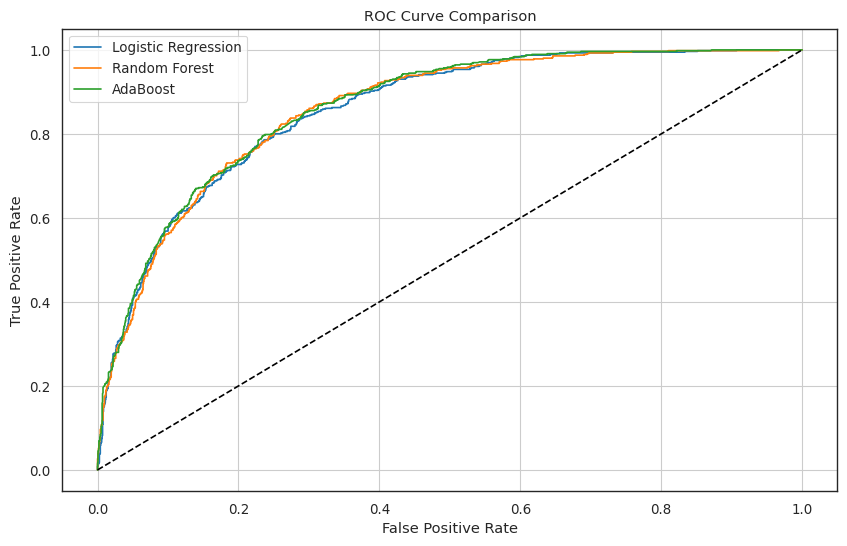

In [31]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name}')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

### 2. 混淆矩阵图（以最佳模型AdaBoost为例）

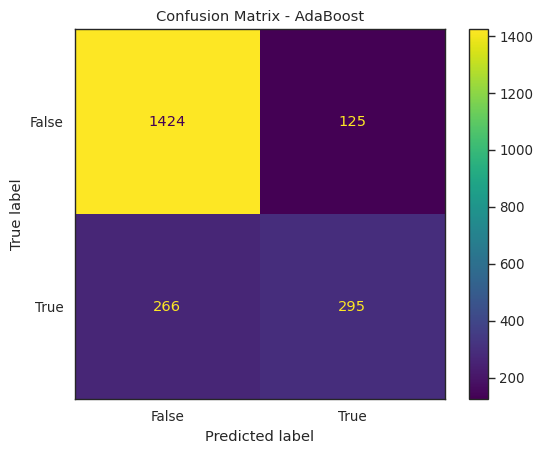

In [32]:
best_model = best_ada  # 你的最佳模型
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix - AdaBoost')
plt.show()

### 3. AdaBoost 特征重要性图

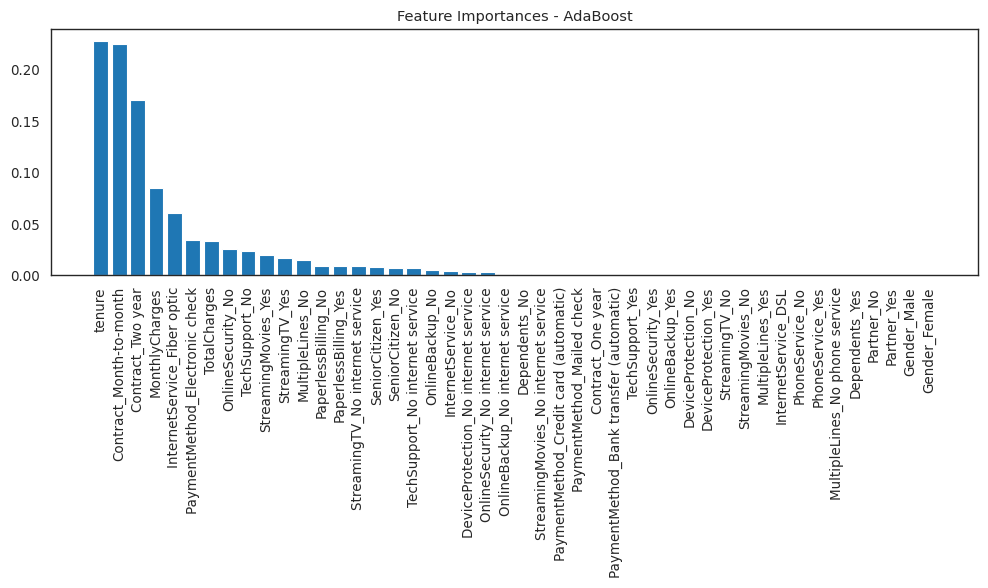

In [33]:
importances = best_ada.feature_importances_
features = X_train.columns

# 排序（从大到小）
indices = np.argsort(importances)[::-1]

# 画图
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - AdaBoost")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

从图中可以看出，最重要的特征是tenure, Contract_Month-to-month, Contract_Two_year.

# 项目结论

本项目旨在通过机器学习方法，预测电信公司客户的流失行为。我们对 Telco 客户数据进行了数据清洗、特征工程、模型训练与评估，得到以下结论：

## 🔍 数据洞察
- 客户流失与**服务周期（tenure）**以及合约类型（如 **Month-to-month** 合约）高度相关。
- 流失用户更可能是签署短期合约的客户，长期合约客户（如 Two-year）流失率显著更低。

## 🤖 模型表现
我们比较了多个机器学习模型，主要结果如下：

| 模型                | 准确率 | AUC    | 精确率 | 召回率 | F1 分数 |
|---------------------|--------|--------|--------|--------|----------|
| Logistic Regression | 0.814  | 0.857  | 0.674  | 0.581  | **0.624** |
| Random Forest       | 0.810  | 0.859  | 0.694  | 0.513  | 0.590 |
| AdaBoost            | 0.815  | **0.864** | **0.702** | 0.526  | 0.601 |

- **逻辑回归**虽然是基础模型，但在 F1 分数上表现最好（0.624），在实际业务中具有良好的解释性。
- **AdaBoost** 在 AUC（0.864）和精确率上最优，适合需要控制误报的场景。
- **Random Forest** 提供了较高的整体性能，适合在需要稳定性的情况下使用。

选择何种模型，需根据业务需求在解释性 vs 性能之间做权衡。


## ⭐ 重要特征分析
- **tenure**（服务时长）是最关键的预测变量，说明客户黏性与服务时间紧密相关。
- 合约类型（**Contract_Month-to-month**, **Contract_Two_year**）在模型中重要性较高，强化了合约机制对客户留存的影响。

## 📌 业务建议
- 针对**月度合约**和**服务时间短**的客户，建议提供更具吸引力的长期服务计划或专属优惠，减少初期流失。
- 将模型预测整合到客户关系管理系统中，用于提前识别流失风险并触发干预措施。

---

整体来看，所构建模型不仅在性能上达标，而且在解释性和业务指导方面均具有实用价值，具备部署上线的潜力。
